<h2 style="color:green;">Distributed ranking plot computations with new impacts methods</h2>

As of demo day #8 (04.04.2025), this demonstration requires a custom branch of `cabinetry`, which can be pulled with 
```
pip install git+https://github.com/MoAly98/cabinetry.git@maly-issue-442
```

and your environment should force install the `main` branch of `pyhf`
```
pip install git+https://github.com/scikit-hep/pyhf.git@main
```

This demonstrates the distribution of ranking computation for a larger and more complex model extracted from `hepdata`. We first need to download the workspace from `hepdata`. We will follow a measurement of the single top-quark production cross-section in the s-channel, [published on `HEPData`](https://www.hepdata.net/record/resource/3386157?landing_page=true). 

In [2]:
import urllib.request

url = "https://www.hepdata.net/record/resource/3386157?view=false"
urllib.request.urlretrieve(url, "complex_workspace.json")

print("Download complete.")

Download complete.


<h3 style="color:green;"> The new impacts methods</h3>

Load the `pyhf` workspace and review the content

In [62]:
import logging
import shutil
import pathlib
import json

import pyhf
import cabinetry

logging.basicConfig(format="%(levelname)s - %(name)s - %(message)s")
logging.getLogger("cabinetry").setLevel(logging.INFO)

# Get the pyhf workspace from the model specs
file_path = pathlib.Path("complex_workspace.json")
ws = json.loads(file_path.read_text())
spec = pyhf.Workspace(ws)
# Model and data
model, data = cabinetry.model_utils.model_and_data(spec)
print(f"  channels: {model.config.channels}")
print(f"     nbins: {model.config.channel_nbins}")
print(f"   samples  [{len(model.config.samples)}]: {model.config.samples}")
print(f" modifiers  [{len(model.config.modifiers)}]: {model.config.modifiers}")
print(f"parameters  [{len(model.config.parameters)}]: {model.config.parameters}")
# List of parameter names
parameters_list = model.config.par_names

model_spec = model.spec
new_model = pyhf.Model(model_spec) # the call to build  model on a worker through serialisable spec
print(new_model.config.poi_name)

  channels: ['mem']
     nbins: {'mem': 18}
   samples  [7]: ['fakes', 'other', 'tb', 'tq', 'tt', 'tw', 'wjets']
 modifiers  [223]: [('EG_RESOLUTION_ALL', 'normsys'), ('EG_SCALE_ALL', 'normsys'), ('JET_CategoryReduction_JET_BJES_Response', 'histosys'), ('JET_CategoryReduction_JET_BJES_Response', 'normsys'), ('JET_CategoryReduction_JET_EffectiveNP_Detector1', 'normsys'), ('JET_CategoryReduction_JET_EffectiveNP_Detector2', 'histosys'), ('JET_CategoryReduction_JET_EffectiveNP_Detector2', 'normsys'), ('JET_CategoryReduction_JET_EffectiveNP_Mixed2', 'histosys'), ('JET_CategoryReduction_JET_EffectiveNP_Mixed2', 'normsys'), ('JET_CategoryReduction_JET_EffectiveNP_Mixed3', 'normsys'), ('JET_CategoryReduction_JET_EffectiveNP_Modelling1', 'histosys'), ('JET_CategoryReduction_JET_EffectiveNP_Modelling1', 'normsys'), ('JET_CategoryReduction_JET_EffectiveNP_Modelling2', 'histosys'), ('JET_CategoryReduction_JET_EffectiveNP_Modelling2', 'normsys'), ('JET_CategoryReduction_JET_EffectiveNP_Modelling3',

INFO - cabinetry.visualize.utils - saving figure as complex_example/modifier_grid.pdf


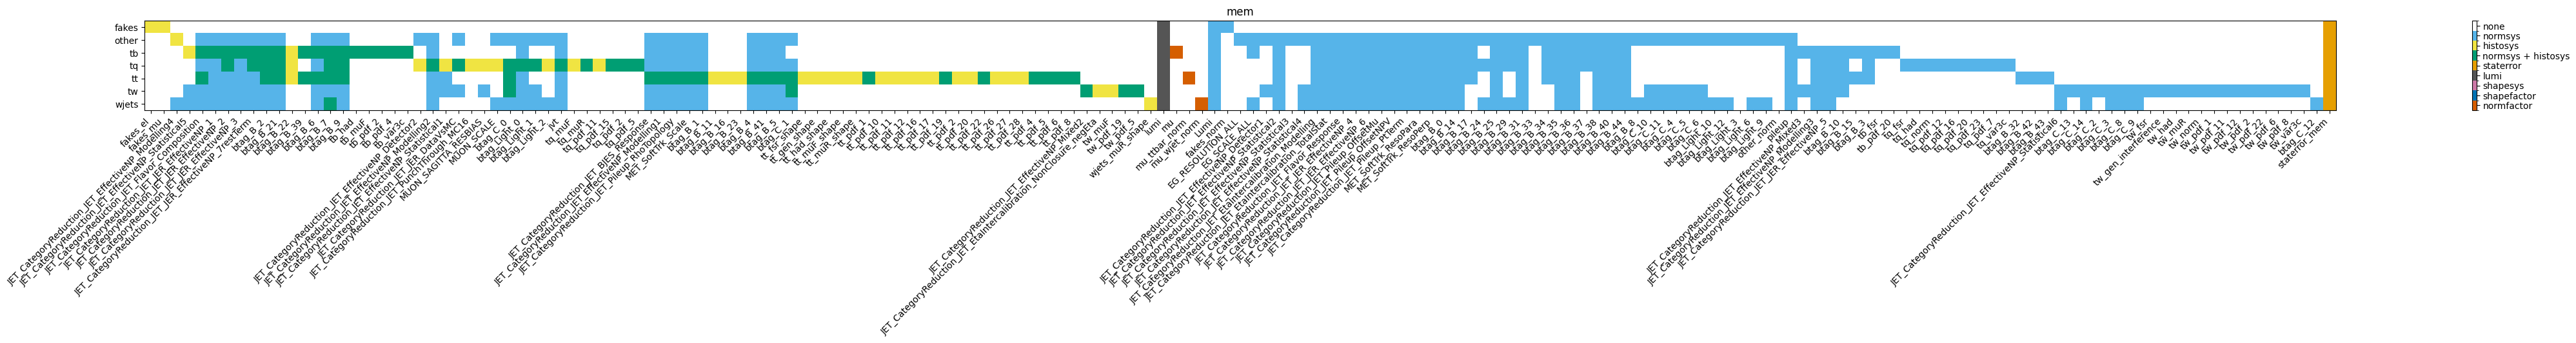

In [59]:
cabinetry.visualize.modifier_grid(model, figure_folder="complex_example/")

Run the nominal fit

In [60]:
%%time
fit_results = cabinetry.fit.fit(model, data)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 390.8                      │             Nfcn = 67864             │
│ EDM = 2.82e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴─────────────────────────────────

CPU times: user 24.5 s, sys: 5.69 s, total: 30.2 s
Wall time: 30.6 s


Create workspace, build model and run fit

INFO - cabinetry.visualize.utils - saving figure as complex_example/data_mc/mem_prefit.pdf
INFO - cabinetry.visualize.utils - saving figure as complex_example/data_mc/mem_postfit.pdf


[{'figure': <Figure size 600x600 with 2 Axes>, 'region': 'mem'}]

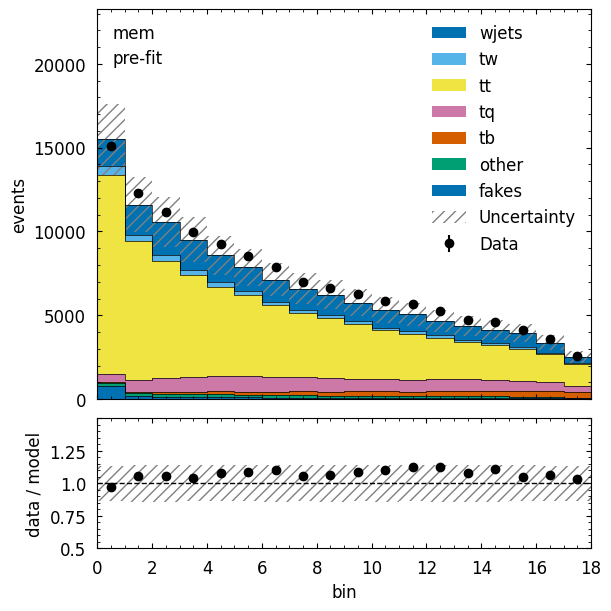

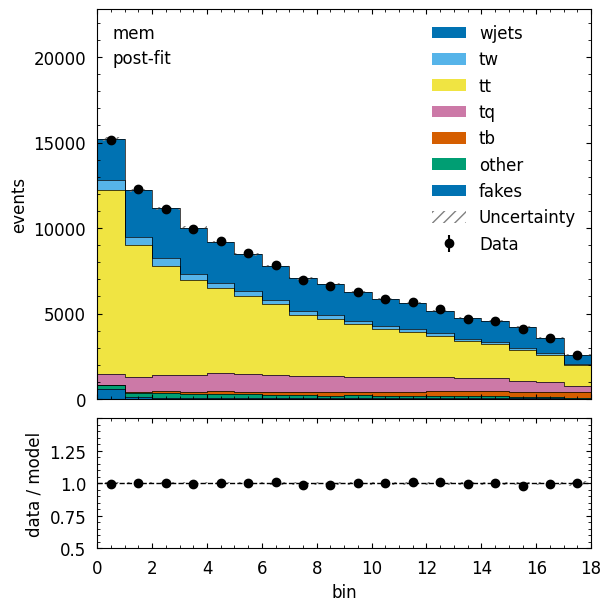

In [28]:
# visualize the pre-fit model prediction and data
prediction_prefit = cabinetry.model_utils.prediction(model)
cabinetry.visualize.data_mc(prediction_prefit, data, figure_folder="complex_example/data_mc/")

# visualize the post-fit model prediction and data
prediction_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
cabinetry.visualize.data_mc(prediction_postfit, data, figure_folder="complex_example/data_mc/")

Check what the nuisance parameter pulls look like

INFO - cabinetry.visualize.utils - saving figure as complex_example/pulls/pulls.pdf


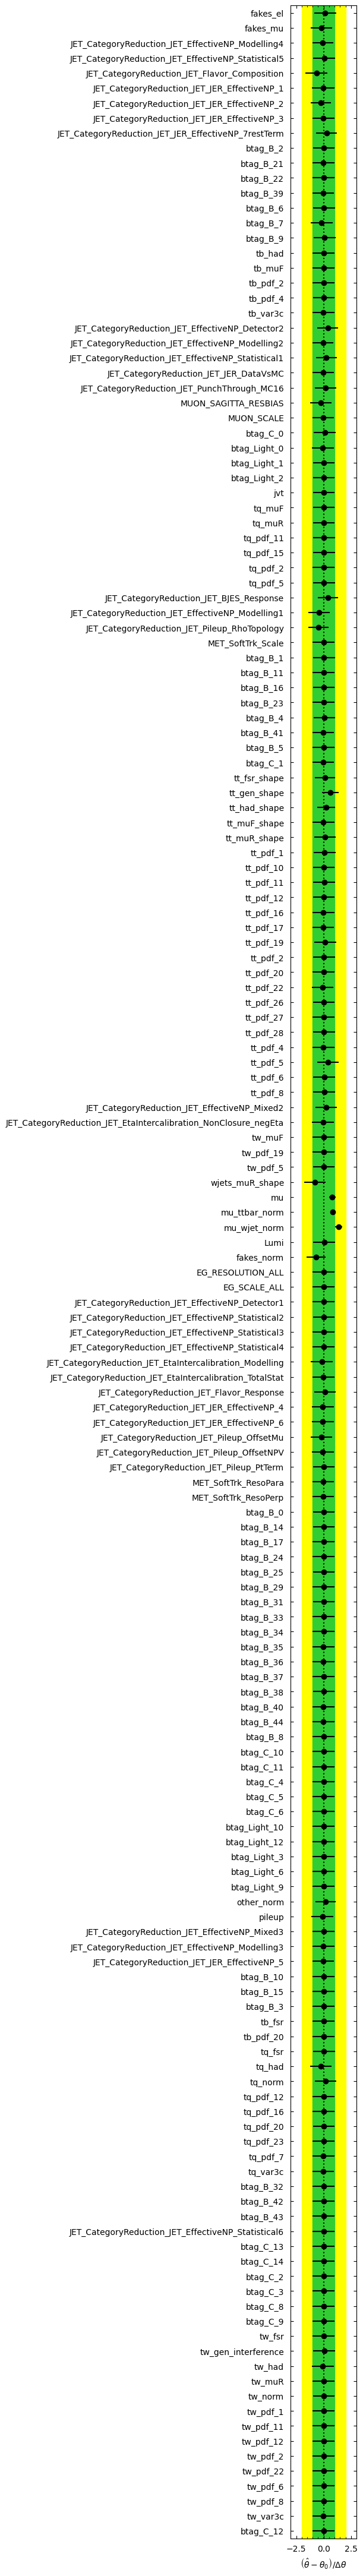

In [29]:
cabinetry.visualize.pulls(
    fit_results, close_figure=True, save_figure=True, figure_folder="complex_example/pulls/"
)

Now we want to run our ranking computations, and we have a choice of which method to use via the `impacts_method` argument in `cabinetry.fit.ranking`. Since we already ran the nominal fit, we can get the impacts with the covariance method instantly (for free)! 

INFO - cabinetry.fit - calculating impact of fakes_el on mu
INFO - cabinetry.fit - calculating impact of fakes_mu on mu
INFO - cabinetry.fit - calculating impact of JET_CategoryReduction_JET_EffectiveNP_Modelling4 on mu
INFO - cabinetry.fit - calculating impact of JET_CategoryReduction_JET_EffectiveNP_Statistical5 on mu
INFO - cabinetry.fit - calculating impact of JET_CategoryReduction_JET_Flavor_Composition on mu
INFO - cabinetry.fit - calculating impact of JET_CategoryReduction_JET_JER_EffectiveNP_1 on mu
INFO - cabinetry.fit - calculating impact of JET_CategoryReduction_JET_JER_EffectiveNP_2 on mu
INFO - cabinetry.fit - calculating impact of JET_CategoryReduction_JET_JER_EffectiveNP_3 on mu
INFO - cabinetry.fit - calculating impact of JET_CategoryReduction_JET_JER_EffectiveNP_7restTerm on mu
INFO - cabinetry.fit - calculating impact of btag_B_2 on mu
INFO - cabinetry.fit - calculating impact of btag_B_21 on mu
INFO - cabinetry.fit - calculating impact of btag_B_22 on mu
INFO - cabin

CPU times: user 749 ms, sys: 56.7 ms, total: 806 ms
Wall time: 436 ms


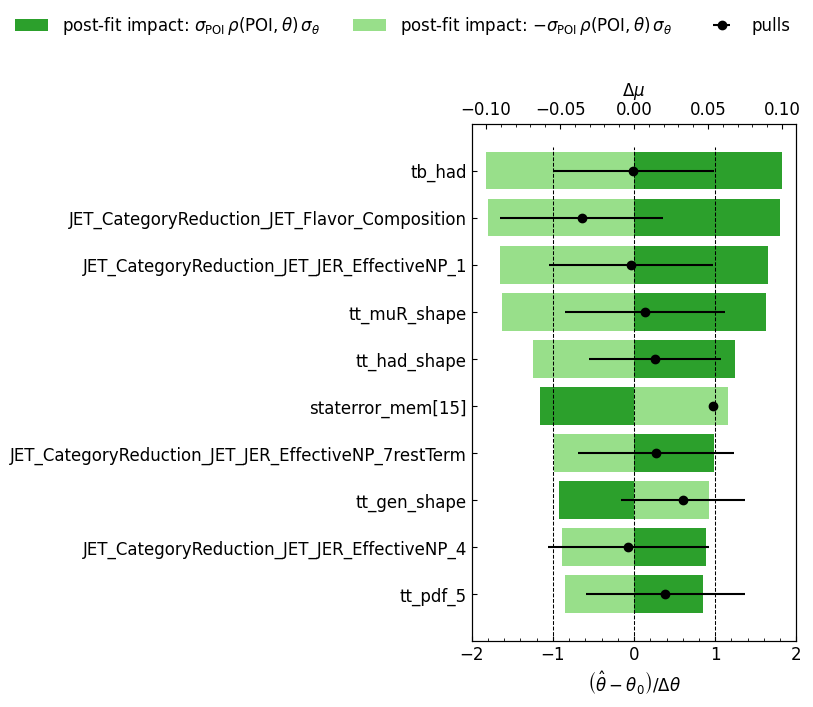

In [30]:
%%time
# Run ranking with the covariance method
ranking_results = cabinetry.fit.ranking(model, data, fit_results=fit_results, impacts_method="covariance")
cabinetry.visualize.ranking(ranking_results, close_figure=True, save_figure=True, figure_folder="complex_example/serial_rankings/", max_pars=10)

It takes 20 seconds to run the nominal fit on an Apple M1 pro chip. For this model, a simple calculation tells us we need (at least) 2 hours to run the ranking with auxiliary data shifting and 4 hours to run the NP-shifting procedure. On `coffea-casa` images in Nebraska, it takes 180-200s to run the nominal fit. This would be 20-40 hours of run-time to finish the ranking computations with methods involving alternative fits.  So, it will make a huge difference to distribute this workload with `dask`.

<h3 style="color:green;">Distributed ranking computation </h3>

Ranking is very computationally intensive in the NP-shifting and Auxiliary data-shifting methods. For this simple configuration, we don't feel it, but for larger models (e.g. 100 of parameters), the single-fit time increases, the number of fits required explodes, a ranking can take days to run sequentially.

Current `cabinetry` implementation of the ranking function does not allow for any form of parallelisation without the user having to re-write elements of the function themselves.
In this next part of the notebook, we demonstrate that there is now: 
- an infrastructure for the user to parallelise calls to the ranking function (4 fits at a time (NP) or 2 fits at a time (AUX))
- an API to get a maximal distribution of individual ranking fits on a cluster via a `dask` client

To run this part, `dask.distributed` is needed in the environment. You should run
```
pip install dask[distributed]
``` 

Note that, in production, `dask` will be an optional dependency in `cabinetry`

<h4 style="color:green;"> Set up dask client </h4>

In [93]:
import time
from dask.distributed import Client, LocalCluster, PipInstall
import cabinetry
import pyhf

COFFEA_CASA = False

def get_client(n_workers=4):
    if not COFFEA_CASA:
        cluster = LocalCluster(n_workers=n_workers, processes=True, threads_per_worker=1)
        client = Client(cluster)
        print(f"Dask dashboard: {cluster.dashboard_link}")
    else:
        dependencies = [
            "git+https://github.com/MoAly98/cabinetry.git@maly-issue-442",
        ]
        client = Client("tls://localhost:8786")
        client.register_plugin(PipInstall(packages=dependencies))
        cluster = None  # no local cluster in this mode
    return cluster, client

def close_client(cluster, client):
    if client:
        client.close()
    if cluster:
        cluster.close()
    return None, None

<h4 style="color:green;"> Parallelising ranking calls </h4>

The ranking function now accepts a list of parameters for which the ranking should be computed. This option can be used to call the ranking function for one parameter at-a-time, and evaluate them in parallel on a cluster.

In [ ]:
def serialize_fit_results(fit_results):
    return {
        "bestfit": fit_results.bestfit.tolist(),
        "uncertainty": fit_results.uncertainty.tolist(),
        "labels": list(fit_results.labels),
        "corr_mat": fit_results.corr_mat.tolist(),
        "best_twice_nll": float(fit_results.best_twice_nll),
    }

def run_dask(func, cluster, client, model_spec, data, fit_results, parameters_list):
    fit_results_serialisable = serialize_fit_results(fit_results)
    try:
        futures = [
            client.submit(func, param, model_spec, data, fit_results_serialisable)
            for param in parameters_list
        ]
        return client.gather(futures)
    except (KeyboardInterrupt, Exception) as e:
        close_client(cluster, client)
        raise e

In [95]:
# Write the function that returns the workload to be distributed
# calls to this function are collected then distributed to the workers
# the use of model spec and a fit results dict is to avoid pickling the model and fit results
# which are not serliasable objects --> is there a better way?
def get_ranking_function(param, model_spec, data, fit_results_serialisable, method="auxdata_shift"):
    fit_results_int = cabinetry.model_utils.FitResults(**fit_results_serialisable)
    model_int = pyhf.Model(model_spec)
    return cabinetry.fit.ranking(
        model_int, data,
        fit_results=fit_results_int,
        impacts_method=method,
        parameters_list=[param],
        poi_name="mu"
    )

In [ ]:
# Setup and run
cluster, client = get_client(n_workers=4)

start = time.time()
try:
    individual_ranking_results = run_dask(
        get_ranking_function,
        cluster,
        client,
        model_spec,
        data,
        fit_results,
        parameters_list[:10],
    )
    elapsed = time.time() - start
    n_workers = len(client.scheduler_info()['workers'])
    print(f"Elapsed for {n_workers} workers: {elapsed:.2f} seconds")
finally:
    cluster, client = close_client(cluster, client)

/Users/moaly/miniforge3/envs/cabinetry_with_pyhf_main/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62331 instead
  warnings.warn(


Dask dashboard: http://127.0.0.1:62331/status


Now that we  have the results from individual ranking calls, we need to combine them and plot! We implemented a utility to allow a user to do this combination quickly and pass the result to plotting functions

INFO - cabinetry.visualize.utils - saving figure as simple_example/dask_rankings/ranking_auxdata_shift.pdf


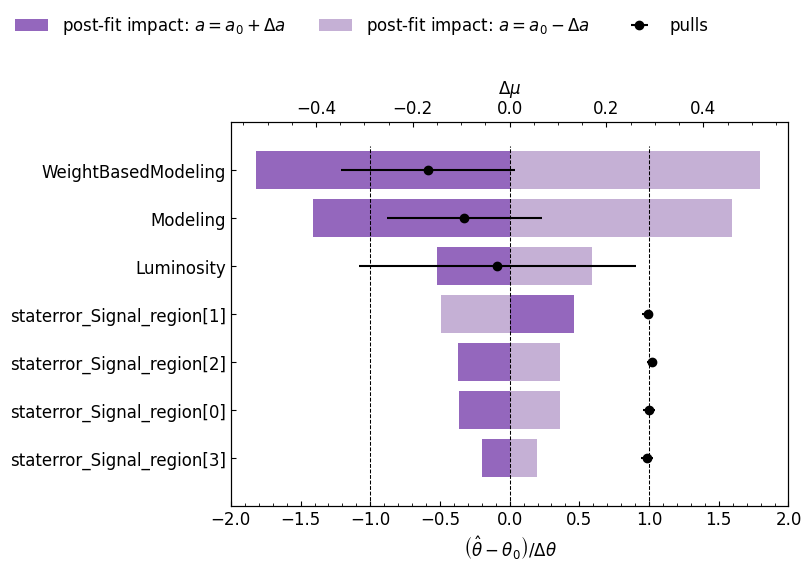

In [ ]:
ranking_results = cabinetry.fit.utils.collect_ranking_results(individual_ranking_results)
cabinetry.visualize.ranking(
    ranking_results, close_figure=True, save_figure=True, figure_folder="complex_example/dask_rankings/", max_pars=10
)

<h4 style="color:green;"> Parallelising fit calls </h4>

The user can instead choose to let cabinetry handle the parallelisation for them by passing a dask client to the ranking funciton call. Behind the scenes, cabinetry will collect individual calls to the **fit** function, and then submit them to the cluster through the client

In [ ]:
cluster, client = get_client(n_workers=4)

start = time.time()
try:
    ranking_result_auxdata_shift = cabinetry.fit.ranking(
        model,
        data,
        fit_results=fit_results,
        impacts_method="auxdata_shift",
        parameters_list=parameters_list,
        poi_name="mu",
        client=client
    )
    elapsed = time.time() - start
    n_workers = len(client.scheduler_info()['workers'])
    print(f"Elapsed for {n_workers} workers: {elapsed:.2f} seconds")
finally:
    cluster, client = close_client(cluster, client)

/Users/moaly/miniforge3/envs/cabinetry_with_pyhf_main/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60344 instead
  warnings.warn(
INFO - cabinetry.fit - calculating impact of fakes_el on mu
INFO - cabinetry.fit - calculating impact of fakes_mu on mu
INFO - cabinetry.fit - calculating impact of JET_CategoryReduction_JET_EffectiveNP_Modelling4 on mu
INFO - cabinetry.fit - calculating impact of JET_CategoryReduction_JET_EffectiveNP_Statistical5 on mu
INFO - cabinetry.fit - calculating impact of JET_CategoryReduction_JET_Flavor_Composition on mu
INFO - cabinetry.fit - calculating impact of JET_CategoryReduction_JET_JER_EffectiveNP_1 on mu
INFO - cabinetry.fit - calculating impact of JET_CategoryReduction_JET_JER_EffectiveNP_2 on mu


Dask dashboard: http://127.0.0.1:60344/status


INFO - cabinetry.fit - calculating impact of JET_CategoryReduction_JET_JER_EffectiveNP_3 on mu
INFO - cabinetry.fit - calculating impact of JET_CategoryReduction_JET_JER_EffectiveNP_7restTerm on mu
INFO - cabinetry.fit - calculating impact of btag_B_2 on mu


AttributeError: 'Client' object has no attribute 'n_workers'

INFO - cabinetry.visualize.utils - saving figure as complex_example/dask_rankings_by_fit/ranking_auxdata_shift.pdf


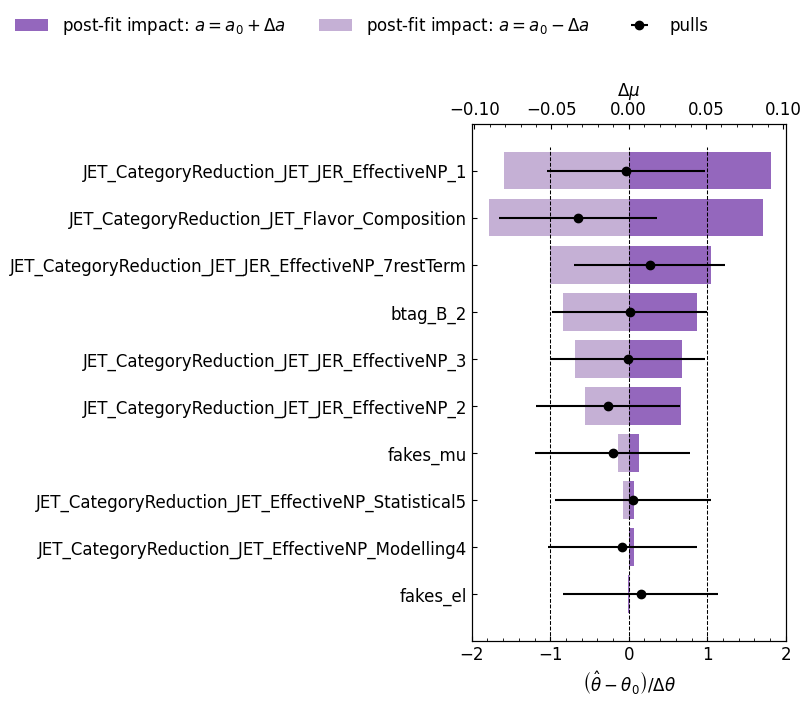

In [ ]:
cabinetry.visualize.ranking(
    ranking_result_auxdata_shift, close_figure=True, save_figure=True, figure_folder="complex_example/dask_rankings_by_fit/", max_pars=10
)